In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import gc
import time
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report, roc_curve, auc
)

from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

import shap
import optuna

# Global Configuration
base_dir = Path().resolve().parent

TUNE_MODE = True # Enable Optuna tuning
N_TRIALS = 20 # Number of trial for Optuna
SEED = 42

print(f"TUNE_MODE: {'ON' if TUNE_MODE else 'OFF'} | Optuna Trials: {N_TRIALS}")

2025-10-16 23:09:10.134388: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 23:09:10.216177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-10-16 23:09:12.573067: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TUNE_MODE: ON | Optuna Trials: 20


In [ ]:
# Step 1: Import the preprocessed data
df_gene = pd.read_csv(base_dir / "dataset/csv/transcriptomic_features.csv", index_col=0)
meta_data = pd.read_csv(base_dir / "dataset/csv/metadata.csv", index_col=0)

In [ ]:
#  Step 2: Prepare data for ML models

#  2.1 Select the top features

# Number of top features (genes) to retain
tr_n = 250 

# Load list of Highly Variable Genes (HVGs) from a precomputed CSV
# Each gene name is expected to be in a single column, no header
hvg_genes = pd.read_csv(base_dir / "dataset/csv/hvg_genes.csv",header=None).squeeze().tolist()

# Keep only HVGs that exist in df_gene columns, preserving order
# Then select the top N genes (tr_n)
tr_top = [g for g in hvg_genes if g in df_gene.columns][:tr_n] 

# Build the feature matrix (X) using the selected top genes
X= df_gene[tr_top]

# Align metadata with df_gene index and extract target column
y = meta_data.loc[df_gene.index,:]['response']


#  2.2 Encode target variable
# Convert categorical response labels to numeric (binary classification)
# 'Responder' -> 1, 'Non-responder' -> 0
y = y.map({"Responder": 1, "Non-responder": 0}).astype(np.int8)

print(X.shape)

(52831, 250)


In [ ]:
# 2.3 Split the data into training and test sets
# Split dataset into training and test sets (80% train, 20% test)
# Stratified split ensures class balance is preserved in both subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)


# 2.4 Standardize the features
scaler = StandardScaler()

# Fit the scaler only on the training data to avoid data leakage
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test sets
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# Step 3: Optuna for Hyper-parameter tunning

# 3.1 Optuna Objective Functions with class balance

# Compute class balance ratio
def class_balance(y):
    """
    Compute class imbalance ratio for weighting.
    Returns ratio (negative_count / positive_count).
    Used to compensate for imbalance in binary classification.
    """
    neg, pos = (y == 0).sum(), (y == 1).sum()
    return neg / pos if pos > 0 else 1.0

# Logistic Regression Objective Function
def tune_logreg(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Logistic Regression using Optuna.
    Hyperparameter: Regularization strength (C).
    """
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    w = class_balance(y_train)
    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=C, class_weight={0: 1, 1: w})
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Random Forest Objective Function
def tune_rf(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Random Forest using Optuna.
    Tuned hyperparameters include depth, splits, and max features.
    """
    w = class_balance(y_train)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800, step=200),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": {0: 1, 1: w}
    }
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# XGBoost Objective Function
def tune_xgb(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning XGBoost using Optuna.
    Includes learning rate, depth, and subsampling parameters.
    """
    w = class_balance(y_train)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": w,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1, random_state=SEED, verbosity=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Artificial Neural Network (ANN) Objective Function
def tune_ann(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning a simple feed-forward ANN using Optuna.
    The model adapts to class imbalance via sample weighting.
    """
    w = class_balance(y_train)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    n1 = trial.suggest_int("n1", 32, 128, step=32)
    n2 = trial.suggest_int("n2", 16, 64, step=16)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(n2, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])

    early = EarlyStopping(patience=5, restore_best_weights=True)
    sample_weights = np.where(y_train == 1, w, 1)
    model.fit(X_train, y_train, sample_weight=sample_weights,
              validation_data=(X_val, y_val),
              epochs=30, batch_size=32, verbose=0, callbacks=[early])
    preds = model.predict(X_val)
    return roc_auc_score(y_val, preds)


[Responder Class Metrics]
Accuracy     : 78.16
Precision    : 62.25
Recall       : 84.37
F1 Score     : 71.64
ROC AUC Score: 87.08

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.91      0.75      0.82      7112
    Responder       0.62      0.84      0.72      3455

     accuracy                           0.78     10567
    macro avg       0.77      0.80      0.77     10567
 weighted avg       0.81      0.78      0.79     10567



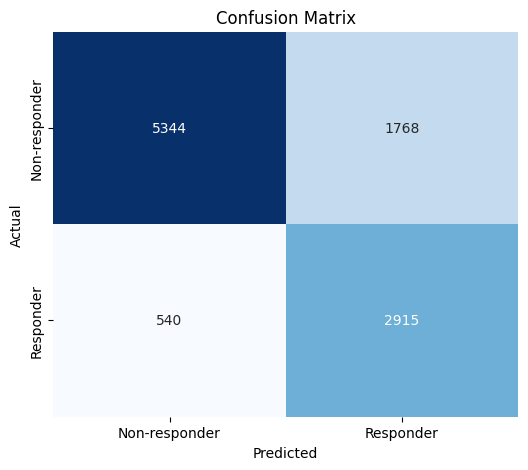

In [ ]:
#  3.2 Run hyperparameter tuning and evaluation for Logistic Regression (LR)

# Step 1: Compute class balance
w = class_balance(y_train)  
print(f"Class balance ratio: neg/pos = {w:.2f}")

# Step 2: Define and run Optuna study
name = "Logistic Regression"
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: tune_logreg(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study.best_value:.3f} | params={study.best_params}")


# Step 3: Refit model on the full training set by best parameters which obtains by Optuna
model_lr = LogisticRegression(
                    **study.best_params, solver="lbfgs", max_iter=1000, class_weight={0: 1, 1: w}
                )
model_lr.fit(X_train, y_train)

# Step 4: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred = model_lr.predict(X_test)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-responder", "Responder"]))

#  Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:10:26,767] A new study created in memory with name: no-name-74143cc0-149f-46bc-975f-01d87c62c437



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/20 [00:03<?, ?it/s]


Best trial: 0. Best value: 0.839532:   0%|          | 0/20 [00:03<?, ?it/s]


Best trial: 0. Best value: 0.839532:   5%|▌         | 1/20 [00:03<01:08,  3.62s/it]

[I 2025-10-16 23:10:30,389] Trial 0 finished with value: 0.8395323419735804 and parameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.8395323419735804.



Best trial: 0. Best value: 0.839532:   5%|▌         | 1/20 [00:07<01:08,  3.62s/it]


Best trial: 0. Best value: 0.839532:   5%|▌         | 1/20 [00:07<01:08,  3.62s/it]


Best trial: 0. Best value: 0.839532:  10%|█         | 2/20 [00:07<01:03,  3.50s/it]

[I 2025-10-16 23:10:33,807] Trial 1 finished with value: 0.835550758197644 and parameters: {'n_estimators': 800, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8395323419735804.



Best trial: 0. Best value: 0.839532:  10%|█         | 2/20 [00:11<01:03,  3.50s/it]


Best trial: 2. Best value: 0.88489:  10%|█         | 2/20 [00:11<01:03,  3.50s/it] 


Best trial: 2. Best value: 0.88489:  15%|█▌        | 3/20 [00:11<01:07,  3.97s/it]

[I 2025-10-16 23:10:38,330] Trial 2 finished with value: 0.8848903957900831 and parameters: {'n_estimators': 400, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  15%|█▌        | 3/20 [00:12<01:07,  3.97s/it]


Best trial: 2. Best value: 0.88489:  15%|█▌        | 3/20 [00:12<01:07,  3.97s/it]


Best trial: 2. Best value: 0.88489:  20%|██        | 4/20 [00:12<00:47,  2.96s/it]

[I 2025-10-16 23:10:39,751] Trial 3 finished with value: 0.8668241374740246 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  20%|██        | 4/20 [00:14<00:47,  2.96s/it]


Best trial: 2. Best value: 0.88489:  20%|██        | 4/20 [00:14<00:47,  2.96s/it]


Best trial: 2. Best value: 0.88489:  25%|██▌       | 5/20 [00:14<00:38,  2.57s/it]

[I 2025-10-16 23:10:41,631] Trial 4 finished with value: 0.8382060589163487 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  25%|██▌       | 5/20 [00:17<00:38,  2.57s/it]


Best trial: 2. Best value: 0.88489:  25%|██▌       | 5/20 [00:17<00:38,  2.57s/it]


Best trial: 2. Best value: 0.88489:  30%|███       | 6/20 [00:17<00:37,  2.69s/it]

[I 2025-10-16 23:10:44,538] Trial 5 finished with value: 0.8435319232611542 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  30%|███       | 6/20 [00:22<00:37,  2.69s/it]


Best trial: 2. Best value: 0.88489:  30%|███       | 6/20 [00:22<00:37,  2.69s/it]


Best trial: 2. Best value: 0.88489:  35%|███▌      | 7/20 [00:22<00:45,  3.50s/it]

[I 2025-10-16 23:10:49,703] Trial 6 finished with value: 0.867145676056492 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  35%|███▌      | 7/20 [00:26<00:45,  3.50s/it]


Best trial: 2. Best value: 0.88489:  35%|███▌      | 7/20 [00:26<00:45,  3.50s/it]


Best trial: 2. Best value: 0.88489:  40%|████      | 8/20 [00:26<00:42,  3.58s/it]

[I 2025-10-16 23:10:53,460] Trial 7 finished with value: 0.875942770711193 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  40%|████      | 8/20 [00:28<00:42,  3.58s/it]


Best trial: 2. Best value: 0.88489:  40%|████      | 8/20 [00:28<00:42,  3.58s/it]


Best trial: 2. Best value: 0.88489:  45%|████▌     | 9/20 [00:28<00:34,  3.17s/it]

[I 2025-10-16 23:10:55,726] Trial 8 finished with value: 0.8574784048938986 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  45%|████▌     | 9/20 [00:32<00:34,  3.17s/it]


Best trial: 2. Best value: 0.88489:  45%|████▌     | 9/20 [00:32<00:34,  3.17s/it]


Best trial: 2. Best value: 0.88489:  50%|█████     | 10/20 [00:32<00:32,  3.27s/it]

[I 2025-10-16 23:10:59,216] Trial 9 finished with value: 0.8481305100685586 and parameters: {'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  50%|█████     | 10/20 [00:34<00:32,  3.27s/it]


Best trial: 2. Best value: 0.88489:  50%|█████     | 10/20 [00:34<00:32,  3.27s/it]


Best trial: 2. Best value: 0.88489:  55%|█████▌    | 11/20 [00:34<00:26,  2.93s/it]

[I 2025-10-16 23:11:01,370] Trial 10 finished with value: 0.8800173946267954 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  55%|█████▌    | 11/20 [00:36<00:26,  2.93s/it]


Best trial: 2. Best value: 0.88489:  55%|█████▌    | 11/20 [00:36<00:26,  2.93s/it]


Best trial: 2. Best value: 0.88489:  60%|██████    | 12/20 [00:36<00:21,  2.71s/it]

[I 2025-10-16 23:11:03,593] Trial 11 finished with value: 0.8800173946267954 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  60%|██████    | 12/20 [00:38<00:21,  2.71s/it]


Best trial: 2. Best value: 0.88489:  60%|██████    | 12/20 [00:38<00:21,  2.71s/it]


Best trial: 2. Best value: 0.88489:  65%|██████▌   | 13/20 [00:38<00:17,  2.55s/it]

[I 2025-10-16 23:11:05,761] Trial 12 finished with value: 0.8800173946267954 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  65%|██████▌   | 13/20 [00:41<00:17,  2.55s/it]


Best trial: 2. Best value: 0.88489:  65%|██████▌   | 13/20 [00:41<00:17,  2.55s/it]


Best trial: 2. Best value: 0.88489:  70%|███████   | 14/20 [00:41<00:15,  2.50s/it]

[I 2025-10-16 23:11:08,155] Trial 13 finished with value: 0.8840209188321129 and parameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  70%|███████   | 14/20 [00:45<00:15,  2.50s/it]


Best trial: 2. Best value: 0.88489:  70%|███████   | 14/20 [00:45<00:15,  2.50s/it]


Best trial: 2. Best value: 0.88489:  75%|███████▌  | 15/20 [00:45<00:15,  3.12s/it]

[I 2025-10-16 23:11:12,701] Trial 14 finished with value: 0.8848903957900831 and parameters: {'n_estimators': 400, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  75%|███████▌  | 15/20 [00:50<00:15,  3.12s/it]


Best trial: 2. Best value: 0.88489:  75%|███████▌  | 15/20 [00:50<00:15,  3.12s/it]


Best trial: 2. Best value: 0.88489:  80%|████████  | 16/20 [00:50<00:14,  3.63s/it]

[I 2025-10-16 23:11:17,518] Trial 15 finished with value: 0.8697364909914503 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  80%|████████  | 16/20 [00:53<00:14,  3.63s/it]


Best trial: 2. Best value: 0.88489:  80%|████████  | 16/20 [00:53<00:14,  3.63s/it]


Best trial: 2. Best value: 0.88489:  85%|████████▌ | 17/20 [00:53<00:10,  3.51s/it]

[I 2025-10-16 23:11:20,755] Trial 16 finished with value: 0.8696752485755256 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  85%|████████▌ | 17/20 [00:57<00:10,  3.51s/it]


Best trial: 2. Best value: 0.88489:  85%|████████▌ | 17/20 [00:57<00:10,  3.51s/it]


Best trial: 2. Best value: 0.88489:  90%|█████████ | 18/20 [00:57<00:07,  3.62s/it]

[I 2025-10-16 23:11:24,627] Trial 17 finished with value: 0.8789654623299998 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  90%|█████████ | 18/20 [01:04<00:07,  3.62s/it]


Best trial: 2. Best value: 0.88489:  90%|█████████ | 18/20 [01:04<00:07,  3.62s/it]


Best trial: 2. Best value: 0.88489:  95%|█████████▌| 19/20 [01:04<00:04,  4.48s/it]

[I 2025-10-16 23:11:31,109] Trial 18 finished with value: 0.8844548941657283 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.



Best trial: 2. Best value: 0.88489:  95%|█████████▌| 19/20 [01:08<00:04,  4.48s/it]


Best trial: 2. Best value: 0.88489:  95%|█████████▌| 19/20 [01:08<00:04,  4.48s/it]


Best trial: 2. Best value: 0.88489: 100%|██████████| 20/20 [01:08<00:00,  4.44s/it]


Best trial: 2. Best value: 0.88489: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]

[I 2025-10-16 23:11:35,466] Trial 19 finished with value: 0.882667925686939 and parameters: {'n_estimators': 400, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8848903957900831.
✅ RF best AUC=0.885 | params={'n_estimators': 400, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}



[Responder Class Metrics]
Accuracy     : 78.16
Precision    : 62.25
Recall       : 84.37
F1 Score     : 71.64
ROC AUC Score: 87.08

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.91      0.75      0.82      7112
    Responder       0.62      0.84      0.72      3455

     accuracy                           0.78     10567
    macro avg       0.77      0.80      0.77     10567
 weighted avg       0.81      0.78      0.79     10567



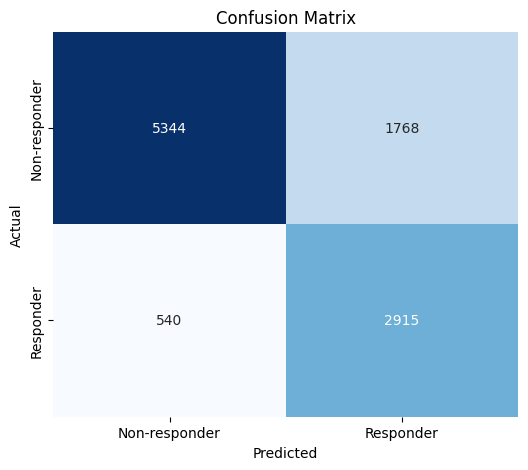

In [ ]:
#  3.3 Run hyperparameter tuning and evaluation for Random Forest (RF)

# Step 1: Define and run Optuna study
name = "RF"
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: tune_rf(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_rf.best_value:.3f} | params={study_rf.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_rf = RandomForestClassifier(**study_rf.best_params, random_state=SEED, n_jobs=-1, class_weight={0: 1, 1: w})
model_rf.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_rf = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_rf = model_lr.predict(X_test)   

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_rf)
roc = roc_auc_score(y_test, y_prob_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:11:40,038] A new study created in memory with name: no-name-661afad1-1063-4800-9038-e3e7ae887510



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/20 [00:08<?, ?it/s]


Best trial: 0. Best value: 0.907846:   0%|          | 0/20 [00:08<?, ?it/s]


Best trial: 0. Best value: 0.907846:   5%|▌         | 1/20 [00:08<02:36,  8.26s/it]

[I 2025-10-16 23:11:48,294] Trial 0 finished with value: 0.90784631727667 and parameters: {'learning_rate': 0.2546988054992449, 'max_depth': 9, 'subsample': 0.6445550475220151, 'colsample_bytree': 0.666403725711909, 'n_estimators': 200}. Best is trial 0 with value: 0.90784631727667.



Best trial: 0. Best value: 0.907846:   5%|▌         | 1/20 [00:15<02:36,  8.26s/it]


Best trial: 1. Best value: 0.915867:   5%|▌         | 1/20 [00:15<02:36,  8.26s/it]


Best trial: 1. Best value: 0.915867:  10%|█         | 2/20 [00:15<02:20,  7.79s/it]

[I 2025-10-16 23:11:55,757] Trial 1 finished with value: 0.9158671658994088 and parameters: {'learning_rate': 0.06607798784366883, 'max_depth': 8, 'subsample': 0.6117811873674793, 'colsample_bytree': 0.7048625123120469, 'n_estimators': 200}. Best is trial 1 with value: 0.9158671658994088.



Best trial: 1. Best value: 0.915867:  10%|█         | 2/20 [00:30<02:20,  7.79s/it]


Best trial: 2. Best value: 0.916808:  10%|█         | 2/20 [00:30<02:20,  7.79s/it]


Best trial: 2. Best value: 0.916808:  15%|█▌        | 3/20 [00:30<03:04, 10.87s/it]

[I 2025-10-16 23:12:10,291] Trial 2 finished with value: 0.9168077743653873 and parameters: {'learning_rate': 0.10950898588486821, 'max_depth': 12, 'subsample': 0.9142404368973471, 'colsample_bytree': 0.7836723429003369, 'n_estimators': 200}. Best is trial 2 with value: 0.9168077743653873.



Best trial: 2. Best value: 0.916808:  15%|█▌        | 3/20 [01:16<03:04, 10.87s/it]


Best trial: 3. Best value: 0.92041:  15%|█▌        | 3/20 [01:16<03:04, 10.87s/it] 


Best trial: 3. Best value: 0.92041:  20%|██        | 4/20 [01:16<06:35, 24.73s/it]

[I 2025-10-16 23:12:56,255] Trial 3 finished with value: 0.9204102020834377 and parameters: {'learning_rate': 0.02202949076405576, 'max_depth': 11, 'subsample': 0.6141210159284197, 'colsample_bytree': 0.6268855276962485, 'n_estimators': 800}. Best is trial 3 with value: 0.9204102020834377.



Best trial: 3. Best value: 0.92041:  20%|██        | 4/20 [01:31<06:35, 24.73s/it]


Best trial: 3. Best value: 0.92041:  20%|██        | 4/20 [01:31<06:35, 24.73s/it]


Best trial: 3. Best value: 0.92041:  25%|██▌       | 5/20 [01:31<05:19, 21.31s/it]

[I 2025-10-16 23:13:11,505] Trial 4 finished with value: 0.9019132435993088 and parameters: {'learning_rate': 0.010553475043217062, 'max_depth': 7, 'subsample': 0.9065954913587706, 'colsample_bytree': 0.6678500740509279, 'n_estimators': 400}. Best is trial 3 with value: 0.9204102020834377.



Best trial: 3. Best value: 0.92041:  25%|██▌       | 5/20 [01:56<05:19, 21.31s/it]


Best trial: 5. Best value: 0.920753:  25%|██▌       | 5/20 [01:56<05:19, 21.31s/it]


Best trial: 5. Best value: 0.920753:  30%|███       | 6/20 [01:56<05:15, 22.50s/it]

[I 2025-10-16 23:13:36,325] Trial 5 finished with value: 0.9207528225567455 and parameters: {'learning_rate': 0.03767726687993685, 'max_depth': 9, 'subsample': 0.6976800113413322, 'colsample_bytree': 0.7145645009336403, 'n_estimators': 600}. Best is trial 5 with value: 0.9207528225567455.



Best trial: 5. Best value: 0.920753:  30%|███       | 6/20 [01:59<05:15, 22.50s/it]


Best trial: 5. Best value: 0.920753:  30%|███       | 6/20 [01:59<05:15, 22.50s/it]


Best trial: 5. Best value: 0.920753:  35%|███▌      | 7/20 [01:59<03:32, 16.34s/it]

[I 2025-10-16 23:13:39,982] Trial 6 finished with value: 0.9115781617303456 and parameters: {'learning_rate': 0.10492612070031573, 'max_depth': 4, 'subsample': 0.7880999190295701, 'colsample_bytree': 0.9985222781628614, 'n_estimators': 200}. Best is trial 5 with value: 0.9207528225567455.



Best trial: 5. Best value: 0.920753:  35%|███▌      | 7/20 [02:10<03:32, 16.34s/it]


Best trial: 5. Best value: 0.920753:  35%|███▌      | 7/20 [02:10<03:32, 16.34s/it]


Best trial: 5. Best value: 0.920753:  40%|████      | 8/20 [02:10<02:52, 14.34s/it]

[I 2025-10-16 23:13:50,038] Trial 7 finished with value: 0.9027787458418117 and parameters: {'learning_rate': 0.018534397578065985, 'max_depth': 5, 'subsample': 0.8580164239425865, 'colsample_bytree': 0.7473092379659636, 'n_estimators': 400}. Best is trial 5 with value: 0.9207528225567455.



Best trial: 5. Best value: 0.920753:  40%|████      | 8/20 [02:24<02:52, 14.34s/it]


Best trial: 8. Best value: 0.920823:  40%|████      | 8/20 [02:24<02:52, 14.34s/it]


Best trial: 8. Best value: 0.920823:  45%|████▌     | 9/20 [02:24<02:38, 14.43s/it]

[I 2025-10-16 23:14:04,678] Trial 8 finished with value: 0.9208231591216604 and parameters: {'learning_rate': 0.06371732929945957, 'max_depth': 8, 'subsample': 0.6841219479338723, 'colsample_bytree': 0.8992772998066407, 'n_estimators': 400}. Best is trial 8 with value: 0.9208231591216604.



Best trial: 8. Best value: 0.920823:  45%|████▌     | 9/20 [02:57<02:38, 14.43s/it]


Best trial: 8. Best value: 0.920823:  45%|████▌     | 9/20 [02:57<02:38, 14.43s/it]


Best trial: 8. Best value: 0.920823:  50%|█████     | 10/20 [02:57<03:22, 20.21s/it]

[I 2025-10-16 23:14:37,817] Trial 9 finished with value: 0.9165975596137366 and parameters: {'learning_rate': 0.17667370506713484, 'max_depth': 9, 'subsample': 0.8415414367981948, 'colsample_bytree': 0.777345671484262, 'n_estimators': 800}. Best is trial 8 with value: 0.9208231591216604.



Best trial: 8. Best value: 0.920823:  50%|█████     | 10/20 [03:21<03:22, 20.21s/it]


Best trial: 10. Best value: 0.921643:  50%|█████     | 10/20 [03:22<03:22, 20.21s/it]


Best trial: 10. Best value: 0.921643:  55%|█████▌    | 11/20 [03:22<03:12, 21.44s/it]

[I 2025-10-16 23:15:02,036] Trial 10 finished with value: 0.921642777248805 and parameters: {'learning_rate': 0.04196962706104653, 'max_depth': 6, 'subsample': 0.9947125914885204, 'colsample_bytree': 0.9262331926778731, 'n_estimators': 1000}. Best is trial 10 with value: 0.921642777248805.



Best trial: 10. Best value: 0.921643:  55%|█████▌    | 11/20 [03:45<03:12, 21.44s/it]


Best trial: 11. Best value: 0.921701:  55%|█████▌    | 11/20 [03:45<03:12, 21.44s/it]


Best trial: 11. Best value: 0.921701:  60%|██████    | 12/20 [03:45<02:57, 22.20s/it]

[I 2025-10-16 23:15:25,997] Trial 11 finished with value: 0.9217006491060133 and parameters: {'learning_rate': 0.045396978512632205, 'max_depth': 6, 'subsample': 0.9859031181293889, 'colsample_bytree': 0.9106967719840564, 'n_estimators': 1000}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  60%|██████    | 12/20 [04:10<02:57, 22.20s/it]


Best trial: 11. Best value: 0.921701:  60%|██████    | 12/20 [04:10<02:57, 22.20s/it]


Best trial: 11. Best value: 0.921701:  65%|██████▌   | 13/20 [04:10<02:41, 23.04s/it]

[I 2025-10-16 23:15:50,956] Trial 12 finished with value: 0.9202483198718729 and parameters: {'learning_rate': 0.03211293835027379, 'max_depth': 6, 'subsample': 0.9934580251338451, 'colsample_bytree': 0.8809037602848879, 'n_estimators': 1000}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  65%|██████▌   | 13/20 [04:34<02:41, 23.04s/it]


Best trial: 11. Best value: 0.921701:  65%|██████▌   | 13/20 [04:34<02:41, 23.04s/it]


Best trial: 11. Best value: 0.921701:  70%|███████   | 14/20 [04:34<02:19, 23.23s/it]

[I 2025-10-16 23:16:14,637] Trial 13 finished with value: 0.9202943311781261 and parameters: {'learning_rate': 0.03671283716722988, 'max_depth': 6, 'subsample': 0.984472169056929, 'colsample_bytree': 0.874518907520157, 'n_estimators': 1000}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  70%|███████   | 14/20 [04:47<02:19, 23.23s/it]


Best trial: 11. Best value: 0.921701:  70%|███████   | 14/20 [04:47<02:19, 23.23s/it]


Best trial: 11. Best value: 0.921701:  75%|███████▌  | 15/20 [04:47<01:41, 20.21s/it]

[I 2025-10-16 23:16:27,826] Trial 14 finished with value: 0.9179290256999377 and parameters: {'learning_rate': 0.05346375478003307, 'max_depth': 4, 'subsample': 0.9354774770504091, 'colsample_bytree': 0.9618081305913017, 'n_estimators': 800}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  75%|███████▌  | 15/20 [05:14<01:41, 20.21s/it]


Best trial: 11. Best value: 0.921701:  75%|███████▌  | 15/20 [05:14<01:41, 20.21s/it]


Best trial: 11. Best value: 0.921701:  80%|████████  | 16/20 [05:14<01:28, 22.03s/it]

[I 2025-10-16 23:16:54,077] Trial 15 finished with value: 0.9188943727949869 and parameters: {'learning_rate': 0.018922024399888517, 'max_depth': 6, 'subsample': 0.7857304378522889, 'colsample_bytree': 0.834490170411512, 'n_estimators': 1000}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  80%|████████  | 16/20 [05:29<01:28, 22.03s/it]


Best trial: 11. Best value: 0.921701:  80%|████████  | 16/20 [05:29<01:28, 22.03s/it]


Best trial: 11. Best value: 0.921701:  85%|████████▌ | 17/20 [05:29<01:00, 20.13s/it]

[I 2025-10-16 23:17:09,815] Trial 16 finished with value: 0.9208128566591683 and parameters: {'learning_rate': 0.10024292492365992, 'max_depth': 5, 'subsample': 0.949486649062011, 'colsample_bytree': 0.9340620259375736, 'n_estimators': 800}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  85%|████████▌ | 17/20 [06:03<01:00, 20.13s/it]


Best trial: 11. Best value: 0.921701:  85%|████████▌ | 17/20 [06:03<01:00, 20.13s/it]


Best trial: 11. Best value: 0.921701:  90%|█████████ | 18/20 [06:03<00:48, 24.32s/it]

[I 2025-10-16 23:17:43,865] Trial 17 finished with value: 0.9155774568384059 and parameters: {'learning_rate': 0.010860356047457677, 'max_depth': 7, 'subsample': 0.8680549563070212, 'colsample_bytree': 0.8362800536834966, 'n_estimators': 1000}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  90%|█████████ | 18/20 [06:23<00:48, 24.32s/it]


Best trial: 11. Best value: 0.921701:  90%|█████████ | 18/20 [06:23<00:48, 24.32s/it]


Best trial: 11. Best value: 0.921701:  95%|█████████▌| 19/20 [06:23<00:22, 22.92s/it]

[I 2025-10-16 23:18:03,537] Trial 18 finished with value: 0.9177853635840765 and parameters: {'learning_rate': 0.02733513080643241, 'max_depth': 7, 'subsample': 0.9998688287322686, 'colsample_bytree': 0.9366911933901836, 'n_estimators': 600}. Best is trial 11 with value: 0.9217006491060133.



Best trial: 11. Best value: 0.921701:  95%|█████████▌| 19/20 [06:36<00:22, 22.92s/it]


Best trial: 11. Best value: 0.921701:  95%|█████████▌| 19/20 [06:36<00:22, 22.92s/it]


Best trial: 11. Best value: 0.921701: 100%|██████████| 20/20 [06:36<00:00, 19.81s/it]


Best trial: 11. Best value: 0.921701: 100%|██████████| 20/20 [06:36<00:00, 19.80s/it]

[I 2025-10-16 23:18:16,112] Trial 19 finished with value: 0.9185423719931753 and parameters: {'learning_rate': 0.04542325305348374, 'max_depth': 5, 'subsample': 0.7299495040718222, 'colsample_bytree': 0.9872567597840313, 'n_estimators': 600}. Best is trial 11 with value: 0.9217006491060133.
✅ GB best AUC=0.922 | params={'learning_rate': 0.045396978512632205, 'max_depth': 6, 'subsample': 0.9859031181293889, 'colsample_bytree': 0.9106967719840564, 'n_estimators': 1000}



[Responder Class Metrics]
Accuracy     : 83.69
Precision    : 70.77
Recall       : 85.41
F1 Score     : 77.40
ROC AUC Score: 91.89

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.92      0.83      0.87      7112
    Responder       0.71      0.85      0.77      3455

     accuracy                           0.84     10567
    macro avg       0.81      0.84      0.82     10567
 weighted avg       0.85      0.84      0.84     10567



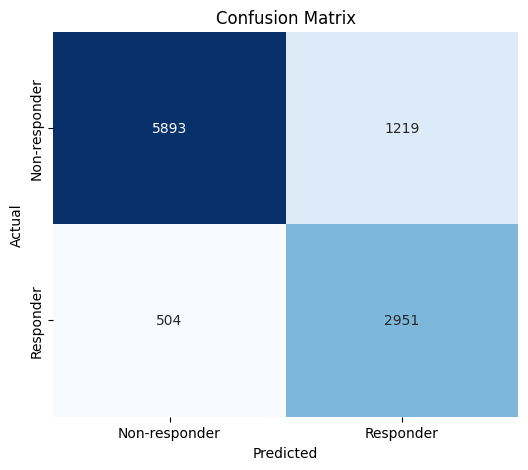

In [ ]:
#  3.4 Run hyperparameter tuning and evaluation for XGBoost (XGB)

# Step 1: Define and run Optuna study
name = "GB"
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(lambda trial: tune_xgb(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_gb.best_value:.3f} | params={study_gb.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_gb = xgb.XGBClassifier(**study_gb.best_params, n_jobs=-1, random_state=SEED, verbosity=0, scale_pos_weight=w)
model_gb.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_gb = model_gb.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_gb = model_gb.predict(X_test)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_gb)
roc = roc_auc_score(y_test, y_prob_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 23:18:39,491] A new study created in memory with name: no-name-094210f1-1380-465a-af59-4f1b777a47b0



  0%|          | 0/20 [00:00<?, ?it/s]

2025-10-16 23:18:39.499847: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



  1/265 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step


 73/265 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


143/265 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step


201/265 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step



  0%|          | 0/20 [00:50<?, ?it/s]


Best trial: 0. Best value: 0.904585:   0%|          | 0/20 [00:50<?, ?it/s]


Best trial: 0. Best value: 0.904585:   5%|▌         | 1/20 [00:50<15:59, 50.51s/it]

[I 2025-10-16 23:19:29,997] Trial 0 finished with value: 0.9045850791343591 and parameters: {'lr': 0.00033965603363055524, 'dropout': 0.580526819278727, 'n1': 96, 'n2': 32}. Best is trial 0 with value: 0.9045850791343591.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step


 68/265 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


132/265 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


201/265 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step



Best trial: 0. Best value: 0.904585:   5%|▌         | 1/20 [01:12<15:59, 50.51s/it]


Best trial: 1. Best value: 0.905103:   5%|▌         | 1/20 [01:12<15:59, 50.51s/it]


Best trial: 1. Best value: 0.905103:  10%|█         | 2/20 [01:12<10:11, 33.96s/it]

[I 2025-10-16 23:19:52,367] Trial 1 finished with value: 0.9051025234927942 and parameters: {'lr': 0.0012210178794725215, 'dropout': 0.2530033671912883, 'n1': 128, 'n2': 16}. Best is trial 1 with value: 0.9051025234927942.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step


 65/265 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


126/265 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


194/265 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


258/265 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step



Best trial: 1. Best value: 0.905103:  10%|█         | 2/20 [01:45<10:11, 33.96s/it]


Best trial: 1. Best value: 0.905103:  10%|█         | 2/20 [01:45<10:11, 33.96s/it]


Best trial: 1. Best value: 0.905103:  15%|█▌        | 3/20 [01:45<09:28, 33.46s/it]

[I 2025-10-16 23:20:25,242] Trial 2 finished with value: 0.9014553563774405 and parameters: {'lr': 0.0009656195305793378, 'dropout': 0.2880628101235364, 'n1': 32, 'n2': 48}. Best is trial 1 with value: 0.9051025234927942.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step


 62/265 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step


130/265 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


192/265 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


255/265 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step



Best trial: 1. Best value: 0.905103:  15%|█▌        | 3/20 [02:13<09:28, 33.46s/it]


Best trial: 3. Best value: 0.905109:  15%|█▌        | 3/20 [02:13<09:28, 33.46s/it]


Best trial: 3. Best value: 0.905109:  20%|██        | 4/20 [02:13<08:17, 31.10s/it]

[I 2025-10-16 23:20:52,707] Trial 3 finished with value: 0.9051089784307138 and parameters: {'lr': 0.001227883198583663, 'dropout': 0.29748790875268316, 'n1': 96, 'n2': 48}. Best is trial 3 with value: 0.9051089784307138.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step


 68/265 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


144/265 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


213/265 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step



Best trial: 3. Best value: 0.905109:  20%|██        | 4/20 [02:40<08:17, 31.10s/it]


Best trial: 3. Best value: 0.905109:  20%|██        | 4/20 [02:40<08:17, 31.10s/it]


Best trial: 3. Best value: 0.905109:  25%|██▌       | 5/20 [02:40<07:26, 29.76s/it]

[I 2025-10-16 23:21:20,108] Trial 4 finished with value: 0.8998848032064316 and parameters: {'lr': 0.00023397377537313926, 'dropout': 0.31646534237312857, 'n1': 128, 'n2': 16}. Best is trial 3 with value: 0.9051089784307138.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step


 59/265 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step


121/265 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step


190/265 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


263/265 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step



Best trial: 3. Best value: 0.905109:  25%|██▌       | 5/20 [03:15<07:26, 29.76s/it]


Best trial: 3. Best value: 0.905109:  25%|██▌       | 5/20 [03:15<07:26, 29.76s/it]


Best trial: 3. Best value: 0.905109:  30%|███       | 6/20 [03:15<07:20, 31.44s/it]

[I 2025-10-16 23:21:54,795] Trial 5 finished with value: 0.900559042140633 and parameters: {'lr': 0.00034226998143265056, 'dropout': 0.23974210080478572, 'n1': 32, 'n2': 64}. Best is trial 3 with value: 0.9051089784307138.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step


 65/265 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


134/265 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


200/265 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step



Best trial: 3. Best value: 0.905109:  30%|███       | 6/20 [03:48<07:20, 31.44s/it]


Best trial: 3. Best value: 0.905109:  30%|███       | 6/20 [03:48<07:20, 31.44s/it]


Best trial: 3. Best value: 0.905109:  35%|███▌      | 7/20 [03:48<06:58, 32.16s/it]

[I 2025-10-16 23:22:28,449] Trial 6 finished with value: 0.8941337079020397 and parameters: {'lr': 0.00539936063980644, 'dropout': 0.41335851513396643, 'n1': 32, 'n2': 32}. Best is trial 3 with value: 0.9051089784307138.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step


 70/265 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


145/265 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step


216/265 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step



Best trial: 3. Best value: 0.905109:  35%|███▌      | 7/20 [04:38<06:58, 32.16s/it]


Best trial: 3. Best value: 0.905109:  35%|███▌      | 7/20 [04:38<06:58, 32.16s/it]


Best trial: 3. Best value: 0.905109:  40%|████      | 8/20 [04:38<07:33, 37.78s/it]

[I 2025-10-16 23:23:18,270] Trial 7 finished with value: 0.9024849030767224 and parameters: {'lr': 0.0007422578899273268, 'dropout': 0.25155516395339367, 'n1': 32, 'n2': 48}. Best is trial 3 with value: 0.9051089784307138.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step


 72/265 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


137/265 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


204/265 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step



Best trial: 3. Best value: 0.905109:  40%|████      | 8/20 [05:12<07:33, 37.78s/it]


Best trial: 8. Best value: 0.906204:  40%|████      | 8/20 [05:12<07:33, 37.78s/it]


Best trial: 8. Best value: 0.906204:  45%|████▌     | 9/20 [05:12<06:42, 36.62s/it]

[I 2025-10-16 23:23:52,337] Trial 8 finished with value: 0.906203646868217 and parameters: {'lr': 0.0027856076115740937, 'dropout': 0.2902222148733605, 'n1': 96, 'n2': 64}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step


 73/265 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


149/265 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


220/265 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step



Best trial: 8. Best value: 0.906204:  45%|████▌     | 9/20 [05:40<06:42, 36.62s/it]


Best trial: 8. Best value: 0.906204:  45%|████▌     | 9/20 [05:40<06:42, 36.62s/it]


Best trial: 8. Best value: 0.906204:  50%|█████     | 10/20 [05:40<05:37, 33.74s/it]

[I 2025-10-16 23:24:19,628] Trial 9 finished with value: 0.8950387029174284 and parameters: {'lr': 0.006681977774488752, 'dropout': 0.26482612223280627, 'n1': 128, 'n2': 32}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step


 57/265 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


133/265 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


201/265 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step



Best trial: 8. Best value: 0.906204:  50%|█████     | 10/20 [05:58<05:37, 33.74s/it]


Best trial: 8. Best value: 0.906204:  50%|█████     | 10/20 [05:58<05:37, 33.74s/it]


Best trial: 8. Best value: 0.906204:  55%|█████▌    | 11/20 [05:58<04:20, 28.91s/it]

[I 2025-10-16 23:24:37,593] Trial 10 finished with value: 0.8936691749559093 and parameters: {'lr': 0.0031350473959405704, 'dropout': 0.4028551679038209, 'n1': 64, 'n2': 64}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step


 55/265 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


123/265 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step


191/265 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step



Best trial: 8. Best value: 0.906204:  55%|█████▌    | 11/20 [06:34<04:20, 28.91s/it]


Best trial: 8. Best value: 0.906204:  55%|█████▌    | 11/20 [06:34<04:20, 28.91s/it]


Best trial: 8. Best value: 0.906204:  60%|██████    | 12/20 [06:34<04:08, 31.07s/it]

[I 2025-10-16 23:25:13,607] Trial 11 finished with value: 0.9036885423134855 and parameters: {'lr': 0.0024132082321236493, 'dropout': 0.3556446959269608, 'n1': 96, 'n2': 64}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step


 67/265 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


140/265 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


203/265 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step



Best trial: 8. Best value: 0.906204:  60%|██████    | 12/20 [07:26<04:08, 31.07s/it]


Best trial: 8. Best value: 0.906204:  60%|██████    | 12/20 [07:26<04:08, 31.07s/it]


Best trial: 8. Best value: 0.906204:  65%|██████▌   | 13/20 [07:26<04:23, 37.58s/it]

[I 2025-10-16 23:26:06,146] Trial 12 finished with value: 0.8964117604262828 and parameters: {'lr': 0.000107698706535487, 'dropout': 0.48242022622212866, 'n1': 96, 'n2': 48}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step


 60/265 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


125/265 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


193/265 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


255/265 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step



Best trial: 8. Best value: 0.906204:  65%|██████▌   | 13/20 [07:48<04:23, 37.58s/it]


Best trial: 8. Best value: 0.906204:  65%|██████▌   | 13/20 [07:48<04:23, 37.58s/it]


Best trial: 8. Best value: 0.906204:  70%|███████   | 14/20 [07:48<03:16, 32.80s/it]

[I 2025-10-16 23:26:27,914] Trial 13 finished with value: 0.9034248437905024 and parameters: {'lr': 0.0023125416726272495, 'dropout': 0.20175875152968475, 'n1': 64, 'n2': 64}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step


 55/265 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


104/265 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


157/265 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


207/265 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 8. Best value: 0.906204:  70%|███████   | 14/20 [08:08<03:16, 32.80s/it]


Best trial: 8. Best value: 0.906204:  70%|███████   | 14/20 [08:08<03:16, 32.80s/it]


Best trial: 8. Best value: 0.906204:  75%|███████▌  | 15/20 [08:08<02:24, 28.86s/it]

[I 2025-10-16 23:26:47,632] Trial 14 finished with value: 0.9006032727743563 and parameters: {'lr': 0.001780190255439501, 'dropout': 0.33783474873505326, 'n1': 96, 'n2': 48}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


 66/265 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


129/265 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


189/265 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


251/265 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step



Best trial: 8. Best value: 0.906204:  75%|███████▌  | 15/20 [08:25<02:24, 28.86s/it]


Best trial: 8. Best value: 0.906204:  75%|███████▌  | 15/20 [08:25<02:24, 28.86s/it]


Best trial: 8. Best value: 0.906204:  80%|████████  | 16/20 [08:25<01:41, 25.38s/it]

[I 2025-10-16 23:27:04,927] Trial 15 finished with value: 0.887862529028142 and parameters: {'lr': 0.009713415072295515, 'dropout': 0.4474031027120349, 'n1': 64, 'n2': 64}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step


 55/265 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


115/265 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step


167/265 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


232/265 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 8. Best value: 0.906204:  80%|████████  | 16/20 [08:45<01:41, 25.38s/it]


Best trial: 8. Best value: 0.906204:  80%|████████  | 16/20 [08:45<01:41, 25.38s/it]


Best trial: 8. Best value: 0.906204:  85%|████████▌ | 17/20 [08:45<01:11, 23.81s/it]

[I 2025-10-16 23:27:25,094] Trial 16 finished with value: 0.8999857927770326 and parameters: {'lr': 0.0006021897113046488, 'dropout': 0.358516222311155, 'n1': 96, 'n2': 48}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


 71/265 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


131/265 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


196/265 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step



Best trial: 8. Best value: 0.906204:  85%|████████▌ | 17/20 [09:14<01:11, 23.81s/it]

[I 2025-10-16 23:27:53,574] Trial 17 finished with value: 0.9027982378464647 and parameters: {'lr': 0.0038778405617885805, 'dropout': 0.20071623132285898, 'n1': 64, 'n2': 64}. Best is trial 8 with value: 0.906203646868217.



Best trial: 8. Best value: 0.906204:  85%|████████▌ | 17/20 [09:14<01:11, 23.81s/it]


Best trial: 8. Best value: 0.906204:  90%|█████████ | 18/20 [09:14<00:50, 25.21s/it]


  1/265 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step


 66/265 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


129/265 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


190/265 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


249/265 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



Best trial: 8. Best value: 0.906204:  90%|█████████ | 18/20 [09:33<00:50, 25.21s/it]


Best trial: 8. Best value: 0.906204:  90%|█████████ | 18/20 [09:33<00:50, 25.21s/it]


Best trial: 8. Best value: 0.906204:  95%|█████████▌| 19/20 [09:33<00:23, 23.52s/it]

[I 2025-10-16 23:28:13,135] Trial 18 finished with value: 0.8991329778263025 and parameters: {'lr': 0.0014937714042344043, 'dropout': 0.3111791668403937, 'n1': 128, 'n2': 48}. Best is trial 8 with value: 0.906203646868217.



  1/265 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step


 60/265 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


 81/265 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step 


131/265 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


189/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


256/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



Best trial: 8. Best value: 0.906204:  95%|█████████▌| 19/20 [10:27<00:23, 23.52s/it]


Best trial: 19. Best value: 0.906963:  95%|█████████▌| 19/20 [10:27<00:23, 23.52s/it]


Best trial: 19. Best value: 0.906963: 100%|██████████| 20/20 [10:27<00:00, 32.61s/it]


Best trial: 19. Best value: 0.906963: 100%|██████████| 20/20 [10:27<00:00, 31.37s/it]

[I 2025-10-16 23:29:06,951] Trial 19 finished with value: 0.9069627857248062 and parameters: {'lr': 0.0005150869224812416, 'dropout': 0.5237727368522767, 'n1': 96, 'n2': 32}. Best is trial 19 with value: 0.9069627857248062.
✅ ANN best AUC=0.907 | params={'lr': 0.0005150869224812416, 'dropout': 0.5237727368522767, 'n1': 96, 'n2': 32}



  1/331 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step


 54/331 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step


126/331 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


188/331 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


251/331 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


314/331 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step



[Responder Class Metrics]
Accuracy     : 81.11
Precision    : 65.80
Recall       : 87.93
F1 Score     : 75.27
ROC AUC Score: 90.42

Classification Report:


               precision    recall  f1-score   support

Non-responder       0.93      0.78      0.85      7112
    Responder       0.66      0.88      0.75      3455

     accuracy                           0.81     10567
    macro avg       0.79      0.83      0.80     10567
 weighted avg       0.84      0.81      0.82     10567



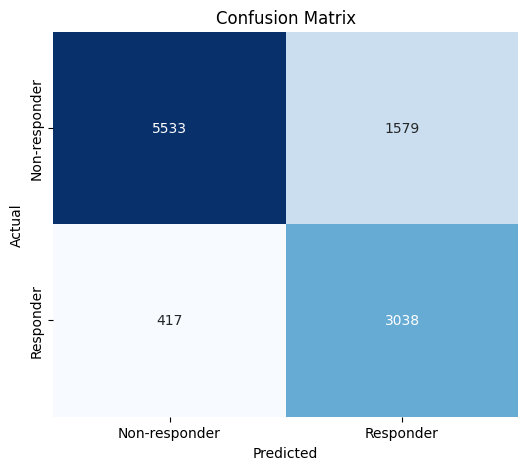

In [ ]:
#  3.5 Run hyperparameter tuning and evaluation for ANN 

# Step 1: Define and run Optuna study
name = 'ANN'
study_ann = optuna.create_study(direction="maximize") 
study_ann.optimize(lambda trial: tune_ann(trial, X_train, X_val, y_train, y_val),
                   n_trials=N_TRIALS, show_progress_bar=True)

print(f"✅ {name} best AUC={study_ann.best_value:.3f} | params={study_ann.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna

# Retrieve best hyperparameters from the ANN Optuna study
best_params = study_ann.best_params

# Compute class imbalance ratio for weighting
w = class_balance(y_train)

#  Build ANN architecture
ann = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(best_params["n1"], activation="relu"),
    layers.Dropout(best_params["dropout"]),
    layers.Dense(best_params["n2"], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile model
ann.compile(
    optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Handle class imbalance via per-sample weighting
sample_weights = np.where(y_train == 1, w, 1)

# Train model
ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=32, verbose=0,
    sample_weight=sample_weights,
    callbacks=[early_stop]
)

# Step 3: Evaluate on test data

# Probability predictions for ROC/AUC
y_prob_ann = ann.predict(X_test)
# Binary predictions using default 0.5 threshold
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Compute evaluation metrics 
conf_mat = confusion_matrix(y_test, y_pred_ann)
roc = roc_auc_score(y_test, y_prob_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
accuracy = accuracy_score(y_test, y_pred_ann)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ann, target_names=["Non-responder", "Responder"]))

# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False, linewidths=0, linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


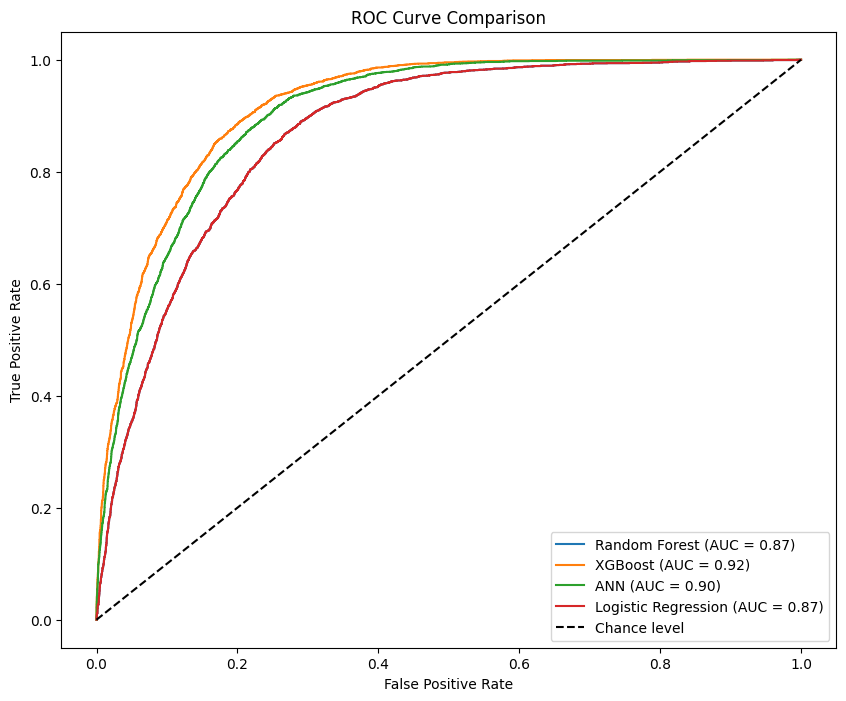

In [ ]:
# Model Comparsion - ROC Curve

# Compute ROC and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_gb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

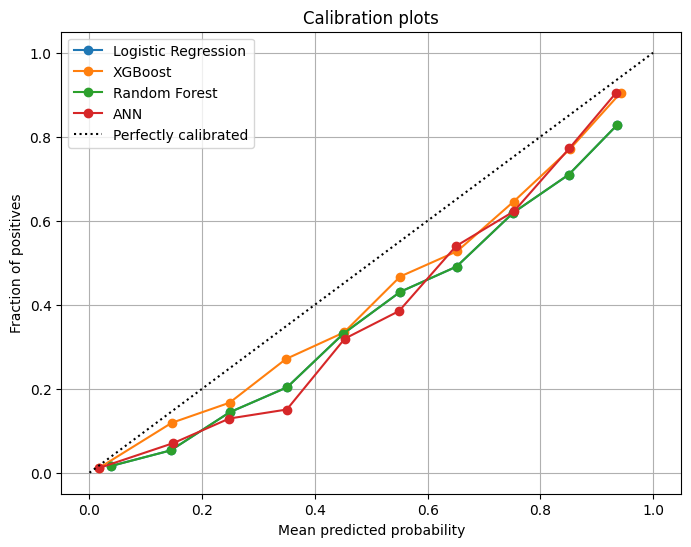

In [ ]:
# Calibration Curver Comparison

# Initialize plot
plt.figure(figsize=(8, 6))

# Define models and their predicted probabilities
for model_name, y_prob in [
    ('Logistic Regression', y_prob),
    ('XGBoost', y_prob_gb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

# Plot
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Model Evaluation using Matthews Correlation Coefficient (MCC)

# Define threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary classes
y_pred_logreg = (y_prob > threshold).astype(int)
y_pred_xgb    = (y_prob_gb > threshold).astype(int)
y_pred_rf     = (y_prob_rf > threshold).astype(int)
y_pred_ann    = (y_prob_ann > threshold).astype(int)

# Compute MCC for each model
mcc_logreg = matthews_corrcoef(y_test, y_pred_logreg)
mcc_xgb    = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf     = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann    = matthews_corrcoef(y_test, y_pred_ann)

print(f"MCC - Logistic Regression: {mcc_logreg:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.6216
MCC - XGBoost: 0.6553
MCC - Random Forest: 0.5620
MCC - ANN: 0.6216


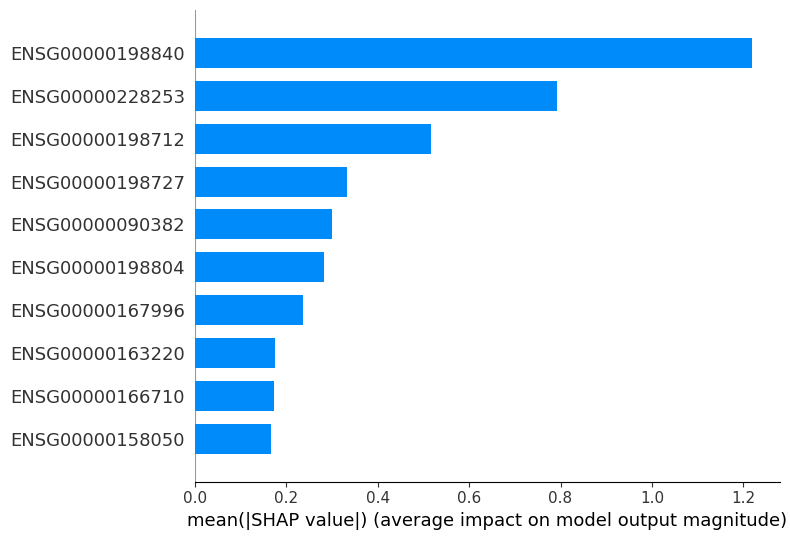

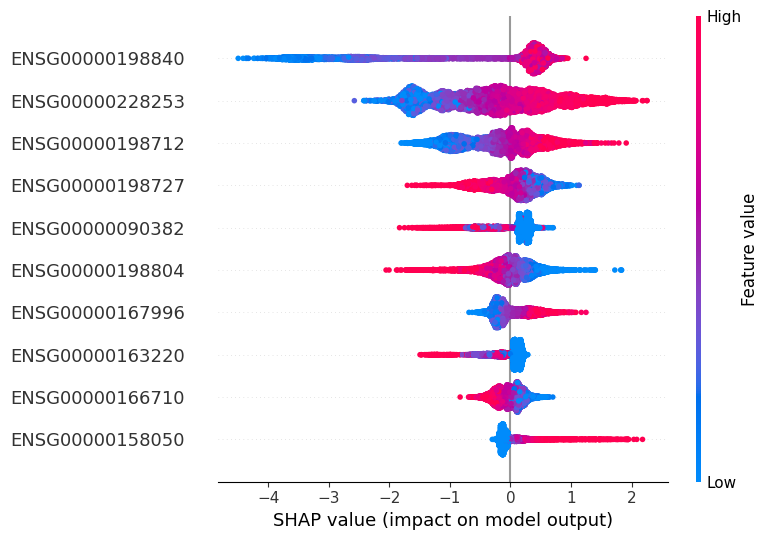

In [ ]:
# Step 4 interpret the results

# Compute SHAP values
explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_test)

# Top 10 features by mean absolute SHAP
top_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-10:]
X_top = X_test[:, top_idx]
shap_top = shap_values[:, top_idx]
feature_names = X.columns[top_idx]

# SHAP summary plots
shap.summary_plot(shap_top, X_top, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_top, X_top, feature_names=feature_names)